# 1) Importando bibliotecas

In [ ]:
# inicializa o GEE
import ee, geemap, eemont, wxee
geemap.ee_initialize()

# importando demais bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import proplot as pplt
import salem
from datetime import datetime
import seaborn as sns
import time
import salem
import warnings
warnings.filterwarnings("ignore")

# 2) Mapa no GEE - `CO`
- `Acesso aos dados`: [Sentinel-5P NRTI CO: Near Real-Time Carbon Monoxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO)
- `Período dos dados`: 2018-11-22T12:00:13Z à 2024-05-18T09:01:55Z
- `Resolução espacial`: 1113.2 metros
- `Resolução temporal`: diária
- `Código realizado por`: Enrique V. Mattos - 19/05/2024

In [100]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Ibitinga'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados. CO_column_number_density esta em unidades de "mol/m^2"
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filter(ee.Filter.date('2024-08-01', '2024-09-01')) \
           .select('CO_column_number_density') \
           .filterBounds(roi)

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa na região
Map.centerObject(roi, zoom=10)

# parâmetros de visualização
vis = {'min': 0, 'max': 150, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa
Map.addLayer(S5P_co.max().clip(roi).multiply(2241.15), vis, 'Mapa de CO')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(roi.style(**style1), {}, 'Brasil')

# barra de cores
Map.add_colorbar_branca(colors=vis['palette'], vmin=vis['min'], vmax=vis['max'], layer_name='CO (DU)')

# exibe na tela
Map

Map(center=[-21.792318417524598, -48.84754127237638], controls=(WidgetControl(options=['position', 'transparen…

# 3) Gera série temporal - `CO`

In [101]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Ibitinga'))

#========================================================================================================================#
#                                               CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados. CO_column_number_density esta em unidades de "mol/m^2"
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filterDate('2024-08-01', '2024-11-01') \
           .select('CO_column_number_density') \
           .filterBounds(roi)

#========================================================================================================================#
#                                              PRODUZ SÉRIE TEMPORAL
#========================================================================================================================#
# gera a serie temporal
S5P_co_ts = S5P_co.getTimeSeriesByRegion(geometry = roi,
                                         bands = 'CO_column_number_density',
                                         reducer = ee.Reducer.max(),
                                         scale = 10_000)

# inserindo os dados numa tabela
S5P_co_ts = geemap.ee_to_df(S5P_co_ts)

# transformando -9999.0 em NaN
S5P_co_ts[S5P_co_ts == -9999] = np.nan

# eliminando os dados NaN
S5P_co_ts = S5P_co_ts.dropna()

# transforma de mol/m^2	 para DU
S5P_co_ts['CO_column_number_density'] = S5P_co_ts['CO_column_number_density']*2241.15

# transformando para DateTime
S5P_co_ts['date'] = pd.to_datetime(S5P_co_ts['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
S5P_co_ts.index = S5P_co_ts['date']

# remove colunas
S5P_co_ts.drop(['reducer', 'date'], inplace=True, axis=1)

# agrupa os dados por DIA
co_agosetout2024_por_dia = S5P_co_ts.groupby(pd.Grouper(freq='1D')).max()['CO_column_number_density']

# salva num arquivo CSV
co_agosetout2024_por_dia.to_csv('output/07_monoxido_carbono_AOD550/tabela_S5P_co_diaria_SP_IBITINGA.csv')

# mostra os dados
co_agosetout2024_por_dia

date
2024-08-01     79.291038
2024-08-02     56.993192
2024-08-03     53.294448
2024-08-04     57.076695
2024-08-05     54.024163
                 ...    
2024-10-27           NaN
2024-10-28    104.211407
2024-10-29     75.531002
2024-10-30     76.534455
2024-10-31     76.116075
Freq: D, Name: CO_column_number_density, Length: 92, dtype: float64

# 4) Plota figura - `CO`

In [102]:
mes, dia, valores = co_agosetout2024_por_dia.index.month.tolist(), co_agosetout2024_por_dia.index.day.tolist(), co_agosetout2024_por_dia.values.tolist()
mes_dia = []
for mesi, diai in zip(mes, dia):
    if mesi == 8:
       mes_dia.append(f'Aug/{str(diai).zfill(2)}')
    elif mesi == 9:
       mes_dia.append(f'Sep/{str(diai).zfill(2)}')
    else: 
       mes_dia.append(f'Oct/{str(diai).zfill(2)}')
#mes_dia

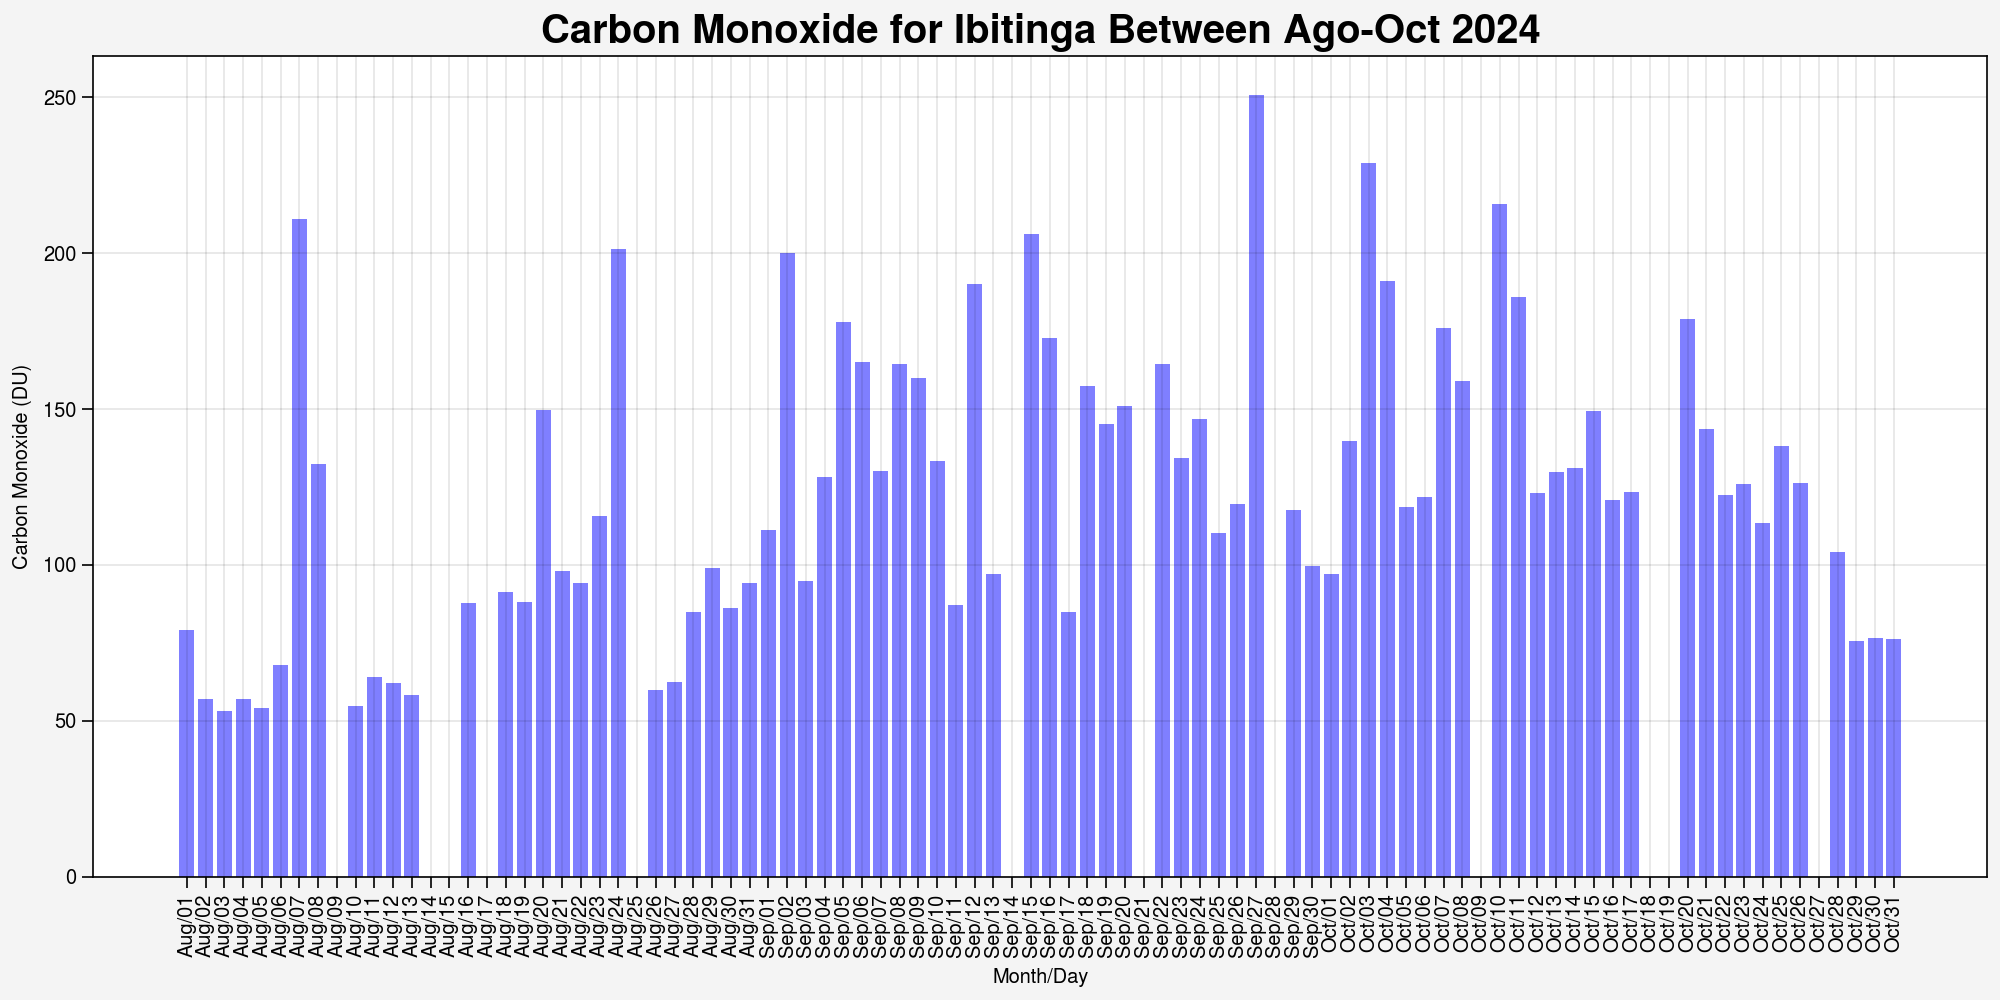

In [103]:
# importa bibliotecas
import proplot as pplt
import warnings
warnings.filterwarnings("ignore")

# cria moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(mes_dia,
       valores,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title='Carbon Monoxide for Ibitinga Between Ago-Oct 2024',
          titleloc='c',
          titleweight='bold',
          titlecolor='black',          
          xlabel='Month/Day',
          ylabel='Carbon Monoxide (DU)',          
          small='10px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xrotation=90)

# salva figura
fig.save(f'output/07_monoxido_carbono_AOD550/Fig_1_CO_por_dia_ago_set_out_2024_sp_IBITINGA.jpg', dpi=300)

# exibe figura na tela
pplt.show()

# 5) Mapa no GEE - `AOD550`
- `Acesso aos dados`: [MCD19A2.061: Terra & Aqua MAIAC Land Aerosol Optical Depth Daily 1km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES)
- `Período dos dados`: 2000-02-24T00:00:00Z–2024-11-26T23:55:00Z
- `Resolução espacial`: 1000 meters
- `Resolução temporal`: diversos horários por dia
- `Código realizado por`: Enrique V. Mattos - 29/11/2024

In [ ]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Ibitinga'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados. CO_column_number_density esta em unidades de "mol/m^2"
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filter(ee.Filter.date('2024-08-01', '2024-09-01')) \
                    .select('Optical_Depth_055') \
                    .filterBounds(roi)

# aplica fator de escala
modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa na região
Map.centerObject(roi, zoom=11)

# parâmetros de visualização
vis = {'min': 0, 'max': 1, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa
Map.addLayer(modis_AOD_550nm.max().clip(roi), vis, 'Mapa de AOD 550nm')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(roi.style(**style1), {}, 'SP')

# barra de cores
Map.add_colorbar_branca(colors=vis['palette'], vmin=vis['min'], vmax=vis['max'], layer_name='CO (DU)')

# exibe na tela
Map

In [ ]:
modis_AOD_550nm

# 6) Gera série temporal - `AOD550` - MODO 1

In [ ]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Ibitinga'))

#========================================================================================================================#
#                                               CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados. CO_column_number_density esta em unidades de "mol/m^2"
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filter(ee.Filter.date('2024-08-01', '2024-11-01')) \
                    .select('Optical_Depth_055') \
                    .filterBounds(roi)

# aplica fator de escala
modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )

#========================================================================================================================#
#                                              PRODUZ SÉRIE TEMPORAL
#========================================================================================================================#
# gera a serie temporal
modis_AOD_550nm_ts = modis_AOD_550nm.getTimeSeriesByRegion(geometry = roi,
                                                           bands = 'Optical_Depth_055',
                                                           reducer = ee.Reducer.max(),
                                                           scale = 10_000)

# inserindo os dados numa tabela
modis_AOD_550nm_ts = geemap.ee_to_df(modis_AOD_550nm_ts)

# transformando -9999.0 em NaN
modis_AOD_550nm_ts[modis_AOD_550nm_ts == -9999] = np.nan

# eliminando os dados NaN
modis_AOD_550nm_ts = modis_AOD_550nm_ts.dropna()

# transformando para DateTime
modis_AOD_550nm_ts['date'] = pd.to_datetime(modis_AOD_550nm_ts['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
modis_AOD_550nm_ts.index = modis_AOD_550nm_ts['date']

# remove colunas
modis_AOD_550nm_ts.drop(['reducer', 'date'], inplace=True, axis=1)

# agrupa os dados por dia
modis_AOD_550nm_agosetout2024_por_dia = modis_AOD_550nm_ts.groupby(pd.Grouper(freq='1D')).max()['Optical_Depth_055']

# salva num arquivo CSV
modis_AOD_550nm_agosetout2024_por_dia.to_csv('output/07_monoxido_carbono_AOD550/tabela_AOD550_diaria_SP_IBITINGA.csv')

# mostra os dados
modis_AOD_550nm_agosetout2024_por_dia

# 6) Gera série temporal - `AOD550` - MODO 2

In [96]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Ibitinga'))

#========================================================================================================================#
#                                              PRODUZ SÉRIE TEMPORAL
#========================================================================================================================#
# loop de cada arquivo da lista files
df_total = pd.DataFrame()
for data in pd.date_range('20240801','20241101',freq='1M'):

    # extrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')
    date = f'{ano}-{mes}' #'2024-09'
    print(date)

    # range de datas
    range = ee.Date(date).getRange('month')

    # carrega os dados. CO_column_number_density esta em unidades de "mol/m^2"
    modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                        .filter(ee.Filter.date(range)) \
                        .select('Optical_Depth_055') \
                        .filterBounds(roi)

    # aplica fator de escala
    modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )

    # gera a serie temporal
    modis_AOD_550nm_ts = modis_AOD_550nm.getTimeSeriesByRegion(geometry = roi,
                                                               bands = 'Optical_Depth_055',
                                                               reducer = ee.Reducer.max(),
                                                               scale = 10_000)
    # inserindo os dados numa tabela
    modis_AOD_550nm_ts = geemap.ee_to_df(modis_AOD_550nm_ts)

    # transformando -9999.0 em NaN
    modis_AOD_550nm_ts[modis_AOD_550nm_ts == -9999] = np.nan

    # eliminando os dados NaN
    modis_AOD_550nm_ts = modis_AOD_550nm_ts.dropna()

    # remove colunas
    modis_AOD_550nm_ts.drop(['reducer'], inplace=True, axis=1)

    # junta a tabela que foi lida com a anterior
    df_total = pd.concat([df_total, modis_AOD_550nm_ts], ignore_index=True)

# transformando para DateTime
df_total['date'] = pd.to_datetime(df_total['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df_total.index = df_total['date']

# agrupa os dados por dia
modis_AOD_550nm_agosetout2024_por_dia = df_total.groupby(pd.Grouper(freq='1D')).max()['Optical_Depth_055']

# salva num arquivo CSV
modis_AOD_550nm_agosetout2024_por_dia.to_csv('output/07_monoxido_carbono_AOD550/tabela_AOD550_diaria_SP_IBITINGA.csv')

# mostra os dados
modis_AOD_550nm_agosetout2024_por_dia

2024-08
2024-09
2024-10
CPU times: total: 0 ns
Wall time: 18.1 s


date
2024-08-01    0.183
2024-08-02      NaN
2024-08-03    0.252
2024-08-04    0.196
2024-08-05    0.196
              ...  
2024-10-27      NaN
2024-10-28    0.261
2024-10-29    0.160
2024-10-30    0.143
2024-10-31    0.286
Freq: D, Name: Optical_Depth_055, Length: 92, dtype: float64

In [ ]:
df_total

# 7) Plota figura - `AOD550`

In [97]:
mes, dia, valores = modis_AOD_550nm_agosetout2024_por_dia.index.month.tolist(), modis_AOD_550nm_agosetout2024_por_dia.index.day.tolist(), modis_AOD_550nm_agosetout2024_por_dia.values.tolist()
mes_dia = []
for mesi, diai in zip(mes, dia):
    if mesi == 8:
       mes_dia.append(f'Aug/{str(diai).zfill(2)}')
    elif mesi == 9:
       mes_dia.append(f'Sep/{str(diai).zfill(2)}')
    else: 
       mes_dia.append(f'Oct/{str(diai).zfill(2)}')
#mes_dia

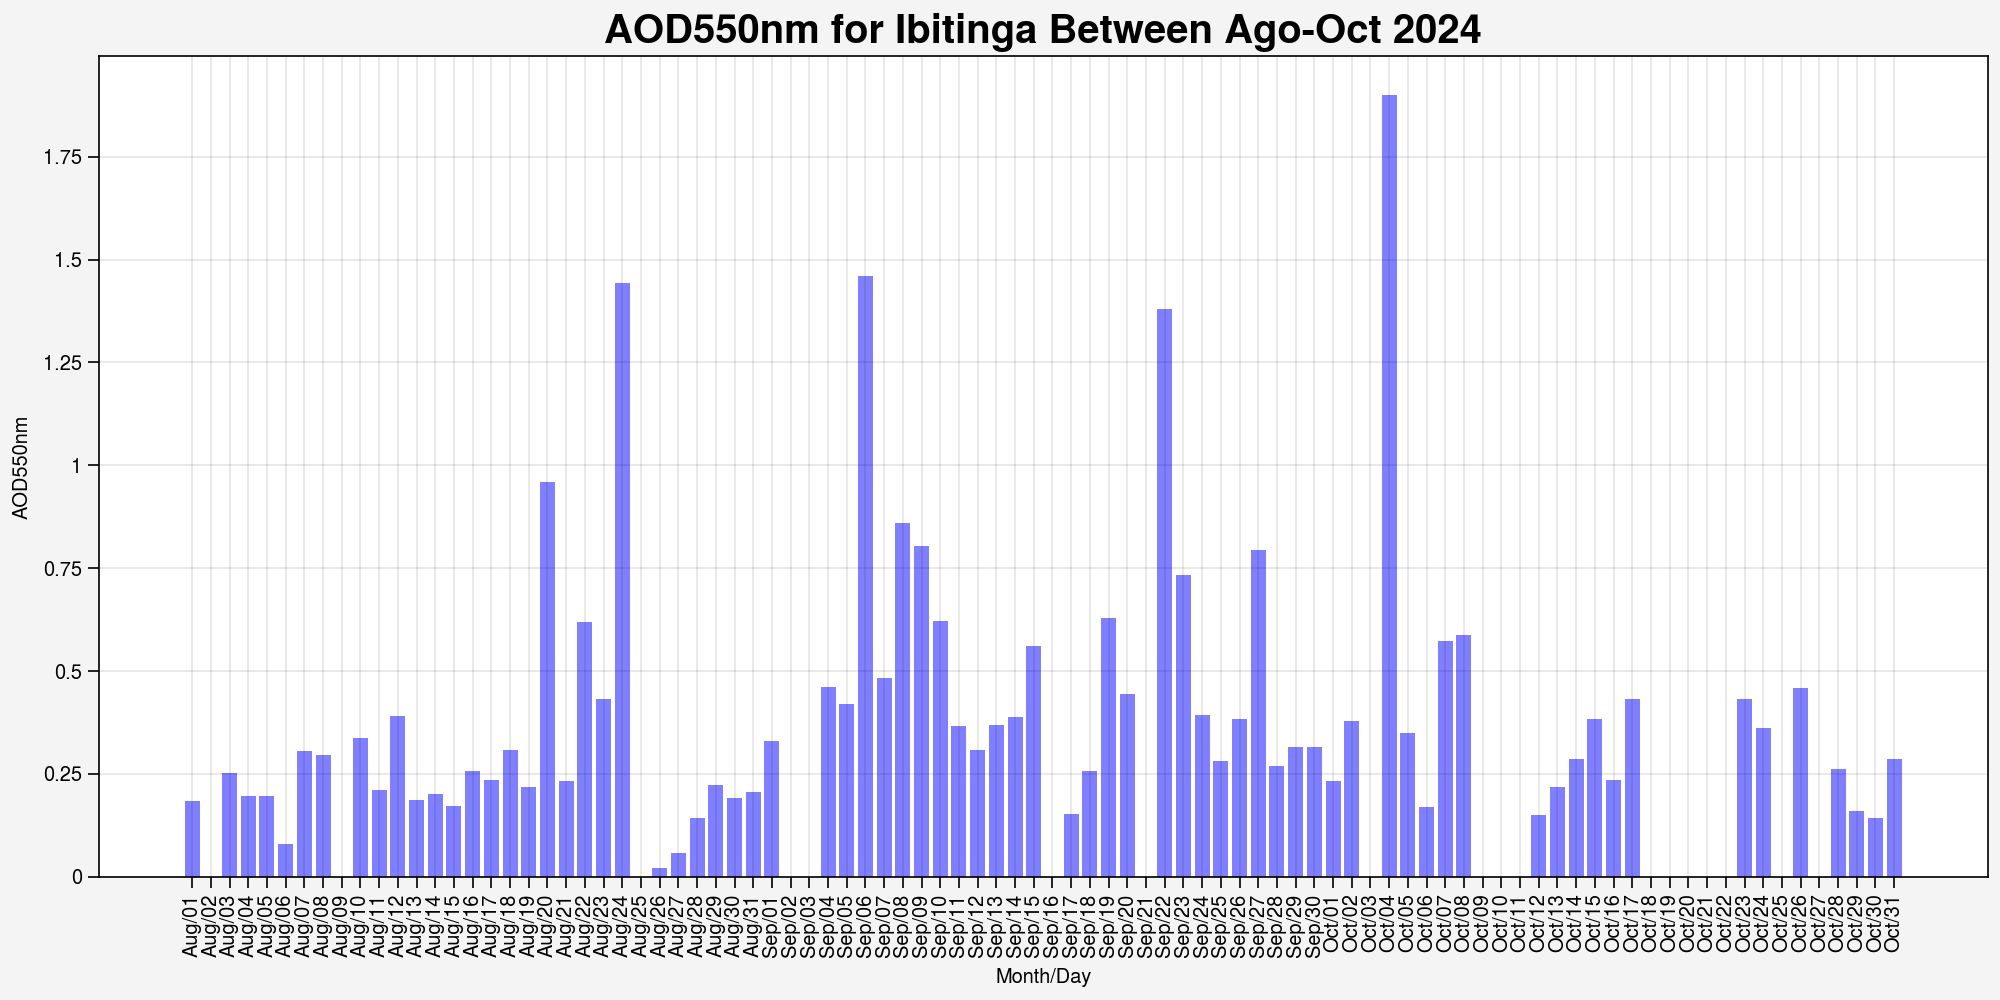

In [98]:
# importa bibliotecas
import proplot as pplt
import warnings
warnings.filterwarnings("ignore")

# cria moldura da figura
fig, ax = pplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(mes_dia,
       valores,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title='AOD550nm for Ibitinga Between Ago-Oct 2024',
          titleloc='c',
          titleweight='bold',
          titlecolor='black',          
          xlabel='Month/Day',
          ylabel='AOD550nm',          
          small='10px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xrotation=90)

# salva figura
fig.save(f'output/07_monoxido_carbono_AOD550/Fig_2_AOD550nm_por_dia_ago_set_out_2024_sp_IBITINGA.jpg', dpi=300)

# exibe figura na tela
pplt.show()